# Homework 4
## Due October 22

## 1 (20 pts) Backpropagation
While the formulas for backpropagation that we've dealt with are generally for fairly large graphs, it's instructive to develop a little bit of intuition by performing it on very small graphs.  Consider the following graph:
<img src=graph.png>
where $x$ is an input, nodes with a $\sigma$ apply the logistic function, nodes with an $I$ apply the identity function (aka don't really do anything), and $L$ is the squared error between a prediction and an observation $y$.  Written out algebraically, this graph says
\begin{align}
a^{(1)}& = x w_1^{(1)} \\
z^{(1)}& = \sigma(a_1) \\
[a^{(2)}_1,a^{(2)}_2]& = z^{(1)} \times [w_1^{(2)}, w_2^{(2)}] \\
[z^{(2)}_1,z^{(2)}_2]& = [\sigma(a^{(2)}_1),\sigma(a^{(2)}_2)] \\
a^{(3)}& = z^{(2)}_1 w_1^{(3)} + z^{(2)}_2 w_2^{(3)} \\
z^{(3)}& = a^{(3)} \\
L &= \frac{1}{2}(z^{(3)} - y)^2 \\
\end{align}
The chain rule can be used to take derivatives of $L$ with respect to the various weights, even far back in the chain.  For example, we could use the chain rule to take the derivative of $L$ with respect to $w^{(3)}_1$ as follows:
$$
\frac{\partial L}{w_1^{(3)}} = \frac{\partial L}{\partial z^{(3)}} \frac{\partial z^{(3)}}{\partial a^{(3)}} \frac{\partial a^{(3)}}{\partial w^{(3)}_1} = (z^{(3)} - y) \times 1 \times z^{(2)}_1
$$
What we've done here is to trace the path from $L$ to the parameter, taking the derivative between the outputs and inputs of each node as we work back through the graph, then evaluated each resulting derivative!

### 1A 
**Derive and evaluate an expression for $$\frac{\partial L}{\partial w^{(2)}_2}.$$**  Compute this derivative for the feature $x$, data $y$, and parameter values $w_j^{(l)}$ given in the following code block.  Compare your results to the [finite difference approximation](https://en.wikipedia.org/wiki/Finite_difference_method) of this derivative computed below. 

In [1]:
import numpy as np

x = 1.0      # Single feature
w_11 = 0.5   # Parameters
w_12 = 0.7
w_22 = -0.3
w_13 = 0.1
w_23 = -0.8
y = 0.5      # Single data point

# Sigmoid function
def sigmoid(a):
    return 1./(1+np.exp(-a))

# Forward pass
def forward(x):
    a_1 = x*w_11
    z_1 = sigmoid(a_1)
    a_12,a_22 = z_1*w_12,z_1*w_22
    z_12,z_22 = sigmoid(a_12),sigmoid(a_22)
    a_3 = z_12 * w_13 + z_22 * w_23
    z_3 = a_3
    L = 0.5*(z_3 - y)**2
    return L

# Compute the forward pass
L_0 = forward(x)

# Very slightly change the value of w_22
w_22 += 1e-5

# Compute the forward pass again
L_1 = forward(x)

# Compute Delta L / Delta w_22 as an approximation for the derivative
dLdw22_fd = (L_1 - L_0)/1e-5

# Reset w_22 to its previous value
w_22 -= 1e-5
print('The finite difference approximation to dL/dw_2^2 is: ',dLdw22_fd)

#! Your function to evaluate the derivative symbolically goes here.



def back(x): #Just using this so I can have all the variables for the formula
    a_1 = x*w_11
    z_1 = sigmoid(a_1)
    a_12,a_22 = z_1*w_12,z_1*w_22
    z_12,z_22 = sigmoid(a_12),sigmoid(a_22)
    a_3 = z_12 * w_13 + z_22 * w_23
    z_3 = a_3
    
    #Derivative calculated on paper and with you in officer hours 
    prop = (z_3 - y ) * w_23 * sigmoid(a_22) * (1-sigmoid(a_22)) * z_1
    
    return prop

#following convention above with L_2, simply returning the derivative 
L_2 = back(x)
print("Actual dL/dw_2^2 =: ", L_2)


The finite difference approximation to dL/dw_2^2 is:  0.09898174062050734
Actual dL/dw_2^2 =:  0.09898163577188605


### 1B (FOR GRAD STUDENTS ONLY)
**Why shouldn't we just use the finite difference method like the one shown above to compute gradients?  Why is backpropagation useful?** 

### 1C (FOR GRAD STUDENTS ONLY) 
**Use the chain rule to determine an expression for**
$$
\frac{\partial L}{\partial w_1^{(1)}}
$$
This one is a little bit harder because there are *two paths* from $w_1^{(1)}$ to $L$ in the graph (unlike in Part 1A)!  There are many ways to deal with this if you have the calculus background to do it, but perhaps the most intuitive way (and what automatic differentiation systems do) is to evaluate the chain rule for both paths and *sum them*.   

## 2 Facial Recognition

The same type of neural network that we've been using to classify digits can just as easily be used to classify other image datasets.  A particularly fun and easy dataset to work with is called the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) dataset, which contains a large database of cropped grayscale images with associated labels (i.e. names).  We can download it using sklearn.datasets as follows:

In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

# Fetch LFW dataset, ensuring that we have at least 50 images per class (i.e. per person)
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

# Extract number of data points, and the height and width of the images for later reshaping
m, h, w = lfw_people.images.shape
n = h*w

# Extract number of classes
N = len(lfw_people.target_names)

# Split the training and test set
X,X_test,y,y_test = train_test_split(lfw_people.data,lfw_people.target)
X/=255.
X_test/=255.

In [3]:
print(m)
print(h, w)

1560
50 37


## 2A Facial Recognition System (40 pts)

**Using the MNIST classifier we developed in pytorch for class as a basis for development, create a new classifier that inputs faces and outputs names.**  
- 1) you'll have to change some things, in particular the number of input features, the number of hidden layer nodes, and also the number of classes!  
- 2) To begin with, use only 8 nodes in your hidden layer.
- 3) Adjust the learning rate, number of epochs, and batch size so that you're confident the network is converged, based either on the cost function or on the test set accuracy

**Train your classifier and report your test set accuracy!**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset


class Net(nn.Module):
    def __init__(self):
        """
        This method is where you'll want to instantiate parameters.
        we do this by creating two linear transformation functions, l1 and l2, which 
        have encoded in it both the weight matrices W_1 and W_2, and the bias vectors
        """
        super(Net,self).__init__()
        #Take 1850 pixels and convert it to our 8 or 16 or 32 hiddehn layers
        self.l1 = nn.Linear(1850, 32) # Transform from input to hidden layer
        
        #takes our hidden layers and turns to our probabilities, m being all people in our set
        self.l2 = nn.Linear(32, m) # Transform from hidden layer to logits
    
    def forward(self,x):
        """
        This method runs the feedforward neural network.  It takes a tensor of size m x 784,
        applies a linear transformation, applies a sigmoidal activation, applies the second linear transform 
        and outputs the logits.
        """
        
        #Feedforward with sigmoid function
        x = torch.sigmoid(self.l1(x))
        #Logit layer
        x = self.l2(x)
        return x

    

In [5]:
X = torch.from_numpy(X)
X_test = torch.from_numpy(X_test)
y = torch.from_numpy(y)
y_test = torch.from_numpy(y_test)
#getting tensors setup

In [6]:
X = X.to(torch.float32) #easier for GPU to process.
X_test = X_test.to(torch.float32)

In [7]:

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
#sending to GPU for fast processing
X = X.to(device)
X_test = X_test.to(device)
y = y.to(device)
y_test = y_test.to(device)

In [8]:
from torch.utils.data import TensorDataset

training_data = TensorDataset(X,y)
test_data = TensorDataset(X_test,y_test)

#choosing batch size, I did 1850/10
batch_size = 185
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 185
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size, 
                                           shuffle=False)

In [9]:

model = Net()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

In [10]:
#setting neural network learning rate. 10^-3
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)


In [11]:
epochs = 1000 #Feedforward and backwards 1000 times
# Loop over the data
for epoch in range(epochs):
    # Loop over each subset of data

    for d,t in train_loader:
        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model(d)
        
        # Compute the loss
        loss = criterion(outputs,t)

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
    # After each epoch, compute the test set accuracy
    total=0
    correct=0
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total += t.size(0)
        correct += (predicted==t).sum()
        
    # Print the epoch, the training loss, and the test set accuracy.
    print(epoch,loss.item(),(100.*correct/total).item())

0 6.788451671600342 0.0
1 6.719138145446777 0.0
2 6.457025527954102 35.128204345703125
3 6.285387992858887 35.128204345703125
4 6.107043266296387 35.128204345703125
5 5.812606334686279 35.128204345703125
6 5.558988571166992 35.128204345703125
7 5.168325424194336 35.128204345703125
8 5.11331033706665 35.128204345703125
9 4.817673206329346 35.128204345703125
10 4.598522663116455 35.128204345703125
11 4.419545650482178 35.128204345703125
12 4.213878154754639 35.128204345703125
13 4.030856132507324 35.128204345703125
14 3.806328296661377 35.128204345703125
15 3.627627372741699 35.128204345703125
16 3.4493415355682373 35.128204345703125
17 3.2880301475524902 35.128204345703125
18 3.1611664295196533 35.128204345703125
19 3.0214428901672363 35.128204345703125
20 2.913623094558716 35.128204345703125
21 2.745046377182007 35.128204345703125
22 2.751110315322876 35.128204345703125
23 2.7440054416656494 35.128204345703125
24 2.7031033039093018 35.128204345703125
25 2.718118190765381 35.12820434570

206 1.1522587537765503 60.256412506103516
207 1.315191626548767 61.79487228393555
208 1.3246159553527832 62.05128479003906
209 1.2992384433746338 59.230770111083984
210 1.140352487564087 64.10256958007812
211 1.2195144891738892 65.12820434570312
212 1.1608864068984985 60.512821197509766
213 1.17194664478302 61.28205490112305
214 1.1066534519195557 64.35897827148438
215 1.1215251684188843 61.02564239501953
216 1.0119415521621704 62.82051467895508
217 1.1406208276748657 61.5384635925293
218 1.2686647176742554 65.64102935791016
219 1.145983338356018 64.61538696289062
220 1.1933104991912842 65.12820434570312
221 1.440145492553711 63.333335876464844
222 1.0763527154922485 65.3846206665039
223 1.13009512424469 66.4102554321289
224 1.0899385213851929 64.87179565429688
225 0.9893131256103516 65.64102935791016
226 1.0853996276855469 66.92308044433594
227 1.017699122428894 66.4102554321289
228 1.1076405048370361 67.17948913574219
229 1.2323681116104126 65.8974380493164
230 0.9128188490867615 66.

411 0.2305895835161209 81.28205108642578
412 0.3190227448940277 80.51282501220703
413 0.43794047832489014 81.28205108642578
414 0.33287638425827026 80.51282501220703
415 0.3455374538898468 79.74359130859375
416 0.3583697974681854 80.76923370361328
417 0.45533353090286255 81.53846740722656
418 0.37713560461997986 81.28205108642578
419 0.3338373601436615 80.76923370361328
420 0.3479641079902649 81.53846740722656
421 0.26307249069213867 80.76923370361328
422 0.3032799959182739 80.51282501220703
423 0.26069629192352295 80.76923370361328
424 0.28428199887275696 82.56410217285156
425 0.396493136882782 81.02564239501953
426 0.39749887585639954 80.25641632080078
427 0.3221064507961273 82.56410217285156
428 0.3411385715007782 81.53846740722656
429 0.2843117415904999 80.76923370361328
430 0.30875030159950256 82.30769348144531
431 0.3712063431739807 81.02564239501953
432 0.25379157066345215 80.76923370361328
433 0.37990042567253113 81.28205108642578
434 0.32081031799316406 81.02564239501953
435 0

609 0.12879662215709686 81.53846740722656
610 0.1547214537858963 83.33333587646484
611 0.18263135850429535 83.33333587646484
612 0.1534557044506073 82.30769348144531
613 0.11670102179050446 83.0769271850586
614 0.10459907352924347 82.56410217285156
615 0.11040735244750977 82.82051849365234
616 0.15080977976322174 82.82051849365234
617 0.16403818130493164 82.05128479003906
618 0.12254598736763 82.82051849365234
619 0.09336017072200775 81.79487609863281
620 0.12261240184307098 83.0769271850586
621 0.122169628739357 82.30769348144531
622 0.1469094604253769 81.02564239501953
623 0.11099906265735626 83.33333587646484
624 0.15070229768753052 82.56410217285156
625 0.11175231635570526 82.56410217285156
626 0.13083960115909576 82.05128479003906
627 0.13031239807605743 83.33333587646484
628 0.10956896096467972 82.82051849365234
629 0.1670164316892624 82.30769348144531
630 0.1141052395105362 83.5897445678711
631 0.1934567093849182 82.30769348144531
632 0.07962150871753693 81.28205108642578
633 0.

808 0.07017997652292252 83.0769271850586
809 0.0679539144039154 83.33333587646484
810 0.06722940504550934 83.5897445678711
811 0.04307013377547264 83.5897445678711
812 0.049487676471471786 82.05128479003906
813 0.06755092740058899 83.84615325927734
814 0.04457812383770943 83.33333587646484
815 0.05676030367612839 83.84615325927734
816 0.04426827281713486 81.79487609863281
817 0.04119541496038437 83.33333587646484
818 0.06574699282646179 84.10256958007812
819 0.05114053189754486 83.0769271850586
820 0.03022921085357666 83.0769271850586
821 0.04545225948095322 82.82051849365234
822 0.03836410120129585 83.84615325927734
823 0.0400649718940258 82.82051849365234
824 0.04422272741794586 84.10256958007812
825 0.03836774080991745 83.33333587646484
826 0.053651466965675354 81.79487609863281
827 0.0498913936316967 82.82051849365234
828 0.07843399047851562 83.0769271850586
829 0.03969855234026909 83.84615325927734
830 0.05051705986261368 84.10256958007812
831 0.058071304112672806 83.3333358764648

## 2B Model Selection (20pts)
We began with a relatively simple model that had only 8 hidden nodes.  If we increase that number do we get better predictive accuracy on the test set?  **Re-run your model using 16 hidden layer nodes.  Is the increase in model complexity (and computing effort) justified?  Why or why not?**  If you answered yes to the previous question, double the number of nodes again, and answer the same questions.  **What is the maximum number of hidden layer nodes that is justified for this task?**

In [12]:
#For my testing I got about a 20% improvement from 8 to 16 hidden layers, so for my implimentation it was well worth the extra
#processing time and resource usage. This was with the 16 nodes
#For 32 nodes I got an improvement of 1-2%, with the cap being 82 percent accuracy and the average around 81 with each epoch
#for 64 nodes I actually lost a bit of accuracy, back to what I was getting with 16 hidden nodes. Therefore I would say 32 is
#the max to go for, and 16 is probably the most efficient. 
#More testing showed that these results are a bit random, sometimes even the 32 layers gets stuck around 79%.

## 2C Feature selection visualization (20 pts)
As in our experiments with MNIST, we're interested in determining exactly what features this neural network is extracting from the raw input data.  **Extract the weight matrix between the input and hidden layer, then reshape and visualize a few of them as images** (note the image width and height parameters defined when we loaded the data).  **Comment on the types of features that this neural network is paying attention to.**

- Note 1) We can extract parameters from our Model class (and transform them into numpy arrays) with the command:

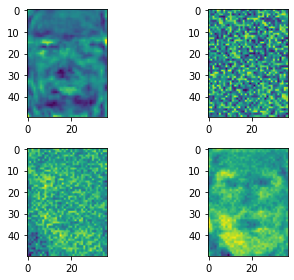

In [13]:
import matplotlib.pyplot as plt

params = [p.cpu().detach().numpy() for p in model.l1.parameters()]
iters = 0
fig=plt.figure()
axes = []

for thing in params[0]:
    #iteratins through our rows of pixels of length 1850
    if(iters == 4):
        break
    #getting the image back from our original n = 50 * 37 
    b = thing.reshape(50,37)
    #storing our subplots
    axes.append( fig.add_subplot(2, 2, iters+1) )
    #plotting the images
    plt.imshow(b)
    #Had to use a manual so I could do thing in params
    iters+=1

#formatting
fig.tight_layout()  
#matplotlib generates images 
plt.show()

##Change subplot to 4, 4, iters+1 and get rid of break block to see all 16 parameters the network is looking at.     
    


- Note 2) Pytorch defines the linear transformation between activation layers using matrices that are transposed relative to how we've seen it so far, i.e. as  
$$
A = X W^T + B^T
$$
This means that you'll want to extract and reshape *rows* rather than *columns* of this weight matrix for visualization as an image.
